In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the train dataset
df = pd.read_csv('/content/drive/MyDrive/real data v1/combined_train_data.csv')

# The first column is the time, we won't use it as a feature as it is common for all data and the last column is the label
X_amplitude = df.iloc[:, 1:53].values # All rows, all columns except the first (time) and last (label)
X_phase = df.iloc[:, 53:-1].values # All rows, all phase columns
X = df.iloc[:, 1:-1].values # All rows, all columns
y = df.iloc[:, -1].values # Labels

# Preprocess the data for amplitude
label_encoder = LabelEncoder()
y_integers = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_integers)
scaler = StandardScaler()
X_amplitude = scaler.fit_transform(X_amplitude)
X_amplitude = X_amplitude.reshape((X_amplitude.shape[0], X_amplitude.shape[1], 1))
X_train_amp, X_val_amp, y_train_amp, y_val_amp = train_test_split(X_amplitude, y_one_hot, test_size=0.2, random_state=42)

# Preprocess the data for phase
scaler = StandardScaler()
X_phase = scaler.fit_transform(X_phase)
X_phase = X_phase.reshape((X_phase.shape[0], X_phase.shape[1], 1))
X_train_phase, X_val_phase, y_train_phase, y_val_phase = train_test_split(X_phase, y_one_hot, test_size=0.2, random_state=42)

# Preprocess the overall data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape((X.shape[0], X.shape[1], 1))
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

In [ ]:
X.shape, y.shape

((183592, 104, 1), (183592,))

In [ ]:
np.unique(y_train_amp)

array([0., 1.], dtype=float32)

In [ ]:
# Build the CNN model
model_amp = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_amp.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(y_train_amp.shape[1], activation='softmax'),
])

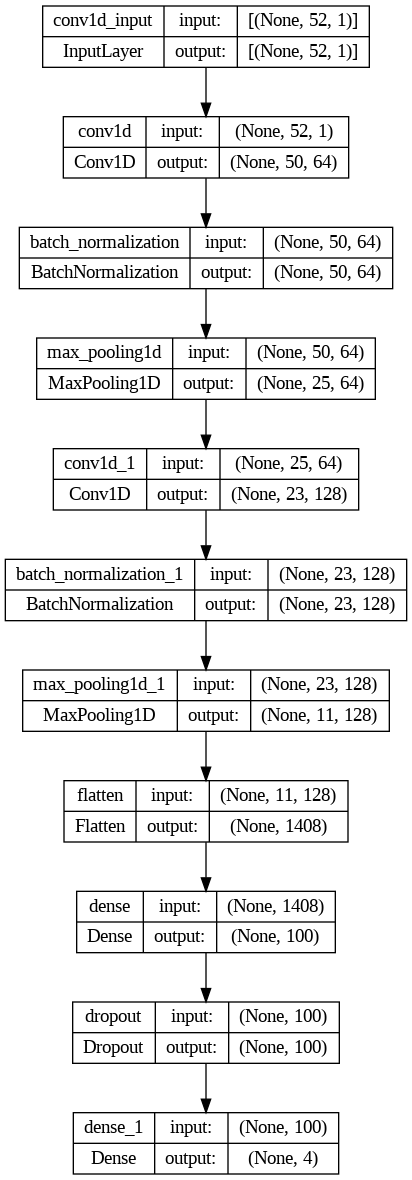

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_amp, to_file='model_amp.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Compile the amplitude model
model_amp.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Train the amplitude model
history_amp = model_amp.fit(X_train_amp, y_train_amp, epochs=10, batch_size=64, validation_data=(X_val_amp, y_val_amp))


Epoch 1/10
2295/2295 [==============================] - 49s 21ms/step - loss: 1.0304 - accuracy: 0.5388 - precision: 0.6751 - recall: 0.3479 - val_loss: 0.8442 - val_accuracy: 0.6442 - val_precision: 0.7899 - val_recall: 0.4110
Epoch 2/10
2295/2295 [==============================] - 45s 20ms/step - loss: 0.8638 - accuracy: 0.6185 - precision: 0.7394 - recall: 0.4614 - val_loss: 0.7673 - val_accuracy: 0.6671 - val_precision: 0.8021 - val_recall: 0.4967
Epoch 3/10
2295/2295 [==============================] - 55s 24ms/step - loss: 0.8113 - accuracy: 0.6435 - precision: 0.7577 - recall: 0.5044 - val_loss: 0.7098 - val_accuracy: 0.7044 - val_precision: 0.8130 - val_recall: 0.5542
Epoch 4/10
2295/2295 [==============================] - 50s 22ms/step - loss: 0.7816 - accuracy: 0.6565 - precision: 0.7672 - recall: 0.5253 - val_loss: 0.6805 - val_accuracy: 0.7125 - val_precision: 0.8120 - val_recall: 0.5896
Epoch 5/10
2295/2295 [==============================] - 53s 23ms/step - loss: 0.7624 - a

In [ ]:
model_amp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 64)            256       
                                                                 
 batch_normalization (Batch  (None, 50, 64)            256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 25, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 128)           24704     
                                                                 
 batch_normalization_1 (Bat  (None, 23, 128)           512       
 chNormalization)                                                
                                                        

In [ ]:
X_train.shape, X_train.shape[1:], X_train_amp.shape[1]

((146873, 104, 1), (104, 1), 52)

In [ ]:

# Build the CNN model for phase
model_phase = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_phase.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(y_train_phase.shape[1], activation='softmax')  # Output layer: one neuron per class
])

# Compile the phase model
model_phase.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Train the phase model
history_phase =model_phase.fit(X_train_phase, y_train_phase, epochs=10, batch_size=64, validation_data=(X_val_phase, y_val_phase))


Epoch 1/10
2295/2295 [==============================] - 50s 21ms/step - loss: 1.3319 - accuracy: 0.3582 - precision_1: 0.5680 - recall_1: 0.0826 - val_loss: 1.1801 - val_accuracy: 0.4514 - val_precision_1: 0.6634 - val_recall_1: 0.1933
Epoch 2/10
2295/2295 [==============================] - 46s 20ms/step - loss: 1.1317 - accuracy: 0.4775 - precision_1: 0.6799 - recall_1: 0.2159 - val_loss: 1.0522 - val_accuracy: 0.5265 - val_precision_1: 0.7678 - val_recall_1: 0.2327
Epoch 3/10
2295/2295 [==============================] - 51s 22ms/step - loss: 1.0619 - accuracy: 0.5173 - precision_1: 0.6995 - recall_1: 0.2816 - val_loss: 1.0537 - val_accuracy: 0.5408 - val_precision_1: 0.7988 - val_recall_1: 0.2083
Epoch 4/10
2295/2295 [==============================] - 46s 20ms/step - loss: 1.0212 - accuracy: 0.5385 - precision_1: 0.7163 - recall_1: 0.3176 - val_loss: 0.9488 - val_accuracy: 0.5974 - val_precision_1: 0.7820 - val_recall_1: 0.3367
Epoch 5/10
2295/2295 [==============================] - 

In [ ]:
# Build the CNN model for both amplitude and phase
model_overall = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')  # Output layer: one neuron per class
])

# Compile the overall model
model_overall.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Configure early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Train the model and store the training history
history_overall = model_overall.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # Add early stopping here
)

Epoch 1/10
2295/2295 [==============================] - 111s 47ms/step - loss: 1.0943 - accuracy: 0.4965 - precision_2: 0.6714 - recall_2: 0.2836 - val_loss: 0.8882 - val_accuracy: 0.5976 - val_precision_2: 0.7712 - val_recall_2: 0.3785
Epoch 2/10
2295/2295 [==============================] - 84s 36ms/step - loss: 0.8932 - accuracy: 0.5887 - precision_2: 0.7378 - recall_2: 0.4220 - val_loss: 0.7636 - val_accuracy: 0.6695 - val_precision_2: 0.8123 - val_recall_2: 0.4971
Epoch 3/10
2295/2295 [==============================] - 82s 36ms/step - loss: 0.8253 - accuracy: 0.6255 - precision_2: 0.7587 - recall_2: 0.4771 - val_loss: 0.7191 - val_accuracy: 0.6878 - val_precision_2: 0.8028 - val_recall_2: 0.5379
Epoch 4/10
2295/2295 [==============================] - 85s 37ms/step - loss: 0.7813 - accuracy: 0.6470 - precision_2: 0.7698 - recall_2: 0.5101 - val_loss: 0.6430 - val_accuracy: 0.7293 - val_precision_2: 0.8359 - val_recall_2: 0.5835
Epoch 5/10
2295/2295 [==============================] -

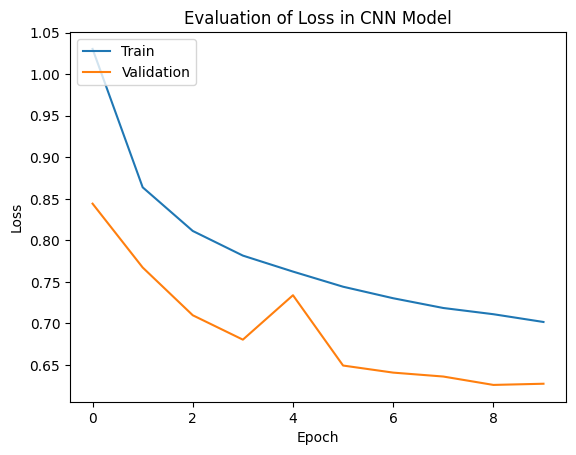

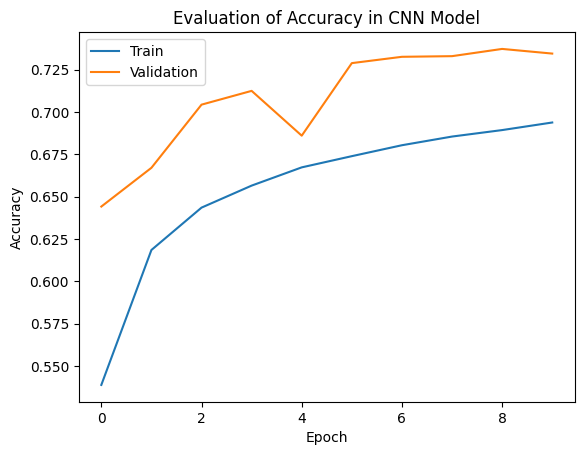

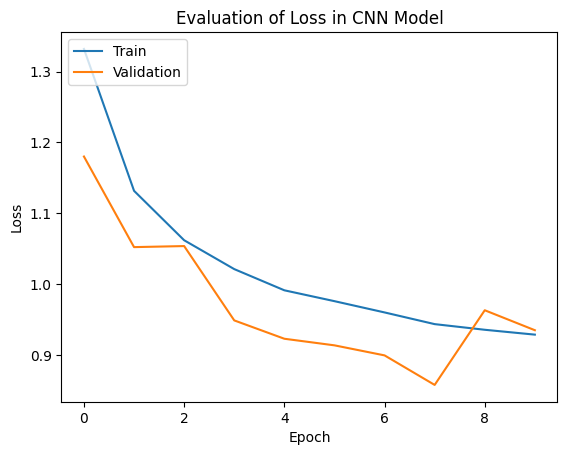

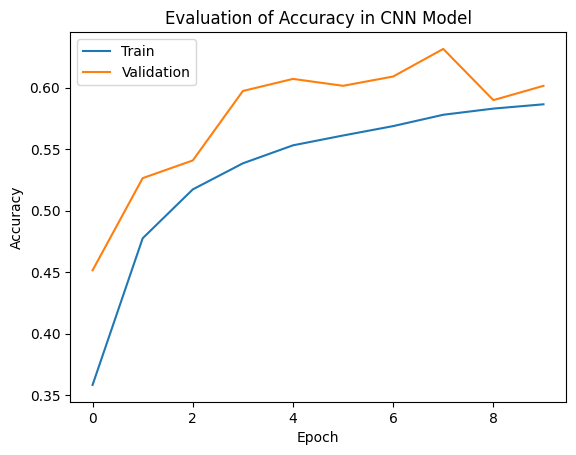

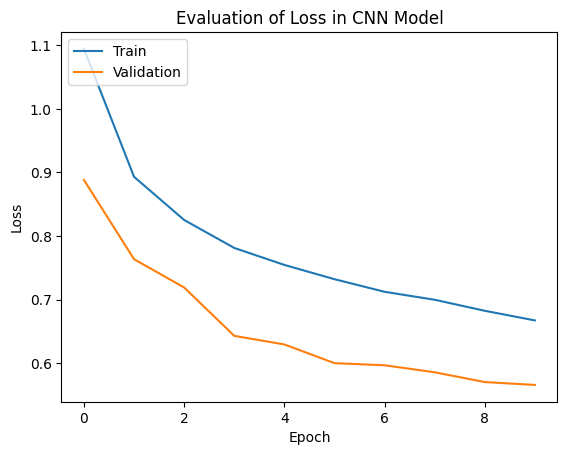

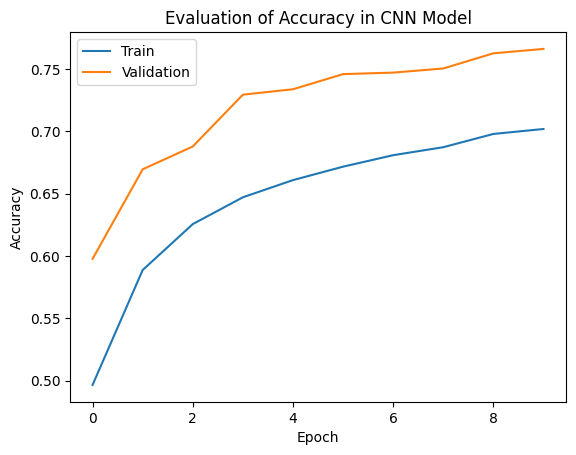

In [ ]:

def Plot(history, model_name):
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(f"Evaluation of Loss in CNN Model")
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.savefig("/content/drive/MyDrive/real data v1/Images/DL Models/Mixed Points/CNN Loss Evaluation, feature: ("+model_name+")#.png")
  plt.show()

  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(f"Evaluation of Accuracy in CNN Model")
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.savefig("/content/drive/MyDrive/real data v1/Images/DL Models/Mixed Points/CNN Accuracy Evaluation: ("+model_name+").png")
  plt.show()


history = [history_amp,history_phase,history_overall]
history_model  = ['Amplitude','Phase','Amplitude & Phase']
for i in range(len(history)):
  Plot(history[i], history_model[i])

In [56]:
# Load the test dataset
df_test = pd.read_csv('/content/drive/MyDrive/real data v1/combined_test_data.csv')

# The first column is the time, we won't use it as a feature as it is common for all data and the last column is the label
X_test_amplitude = df_test.iloc[:, 1:53].values # All rows, all columns except the first (time) and last (label)
X_test_phase = df_test.iloc[:, 53:-1].values # All rows, all phase columns
X_test = df_test.iloc[:, 1:-1].values # All rows, all columns
y_test = df_test.iloc[:, -1].values # Labels

# Preprocess the data for amplitude
label_encoder = LabelEncoder()
y_integers = label_encoder.fit_transform(y_test)
y_test = to_categorical(y_integers)

scaler = StandardScaler()
X_test_amplitude = scaler.fit_transform(X_test_amplitude)
X_test_amplitude = X_test_amplitude.reshape((X_test_amplitude.shape[0], X_test_amplitude.shape[1], 1))

# Preprocess the data for phase
scaler = StandardScaler()
X_test_phase = scaler.fit_transform(X_test_phase)
X_test_phase = X_test_phase.reshape((X_test_phase.shape[0], X_test_phase.shape[1], 1))

# Preprocess the overall data
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [47]:

# Make predictions using the amplitude model
amplitude_predictions = model_amp.predict(X_test_amplitude)

# Make predictions using the phase model
phase_predictions = model_phase.predict(X_test_phase)

# Make predictions using the phase model
overall_predictions = model_overall.predict(X_test)


1435/1435 [==============================] - 8s 5ms/step


In [ ]:
# Evaluate the amplitude model
loss_amp, accuracy_amp, precision_amp, recall_amp = model_amp.evaluate(X_test_amplitude, y_test)
f1_score_amp = 2 * (precision_amp * recall_amp) / (precision_amp + recall_amp) if (precision_amp + recall_amp) != 0 else 0
print("Amplitude Model performance on the test data:")
print(f'Test accuracy: {accuracy_amp:.4f}')
print(f'Test precision: {precision_amp:.4f}')
print(f'Test recall: {recall_amp:.4f}')
print(f'Test F1_Score: {f1_score_amp:.4f}')

1435/1435 [==============================] - 4s 3ms/step - loss: 0.6243 - accuracy: 0.7331 - precision: 0.8286 - recall: 0.6236
Amplitude Model performance on the test data:
Test accuracy: 0.7331
Test precision: 0.8286
Test recall: 0.6236
Test F1_Score: 0.7116


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Convert amplitude predictions to class labels
amplitude_predicted_labels = np.argmax(amplitude_predictions, axis=1)

# Calculate accuracy for amplitude model
amplitude_accuracy__ = accuracy_score(np.argmax(y_test, axis=1), amplitude_predicted_labels)

# Calculate precision for amplitude model
amplitude_precision__ = precision_score(np.argmax(y_test, axis=1), amplitude_predicted_labels, average='weighted')

# Calculate recall for amplitude model
amplitude_recall__ = recall_score(np.argmax(y_test, axis=1), amplitude_predicted_labels, average='weighted')

amplitude_f1_score__ = 2 * (amplitude_precision__ * amplitude_recall__) / (amplitude_precision__ + amplitude_recall__)

print("amplitude Model performance on the test data:")
print(f'Test accuracy: {amplitude_accuracy__:.4f}')
print(f'Test precision: {amplitude_precision__:.4f}')
print(f'Test recall: {amplitude_recall__:.4f}')
print(f'Test f1_Score:{amplitude_f1_score__:.4f}')

amplitude Model performance on the test data:
Test accuracy: 0.7331
Test precision: 0.7371
Test recall: 0.7331
Test f1_Score:0.7351


In [ ]:
# Evaluate the phase model
loss_phase, accuracy_phase, precision_phase, recall_phase = model_phase.evaluate(X_test_phase, y_test)
f1_score_phase = 2 * (precision_phase * recall_phase) / (precision_phase + recall_phase) if (precision_phase + recall_phase) != 0 else 0
print("Phase Model performance on the test data:")
print(f'Test accuracy: {accuracy_phase:.4f}')
print(f'Test precision: {precision_phase:.4f}')
print(f'Test recall: {recall_phase:.4f}')
print(f'Test F1_Score: {f1_score_phase:.4f}')

1435/1435 [==============================] - 5s 3ms/step - loss: 0.9401 - accuracy: 0.5977 - precision_1: 0.8156 - recall_1: 0.3219
Phase Model performance on the test data:
Test accuracy: 0.5977
Test precision: 0.8156
Test recall: 0.3219
Test F1_Score: 0.4616


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Convert amplitude predictions to class labels
phase_predicted_labels = np.argmax(phase_predictions, axis=1)

# Calculate accuracy for amplitude model
phase_accuracy__ = accuracy_score(np.argmax(y_test, axis=1), phase_predicted_labels)

# Calculate precision for amplitude model
phase_precision__ = precision_score(np.argmax(y_test, axis=1), phase_predicted_labels, average='weighted')

# Calculate recall for amplitude model
phase_recall__ = recall_score(np.argmax(y_test, axis=1), phase_predicted_labels, average='weighted')

phase_f1_score__ = 2 * (phase_precision__ * phase_recall__) / (phase_precision__ + phase_recall__)

print("amplitude Model performance on the test data:")
print(f'Test accuracy: {phase_accuracy__:.4f}')
print(f'Test precision: {phase_precision__:.4f}')
print(f'Test recall: {phase_recall__:.4f}')
print(f'Test f1_Score:{phase_f1_score__:.4f}')

amplitude Model performance on the test data:
Test accuracy: 0.5977
Test precision: 0.6284
Test recall: 0.5977
Test f1_Score:0.6127


In [ ]:
# Evaluate the overall model
loss_overall, accuracy_overall, precision_overall, recall_overall = model_overall.evaluate(X_test, y_test)
f1_score_overall = 2 * (precision_overall * recall_overall) / (precision_overall + recall_overall) if (precision_overall + recall_overall) != 0 else 0

print("Overall Model performance on the test data:")
print(f'Test accuracy: {accuracy_overall:.4f}')
print(f'Test precision: {precision_overall:.4f}')
print(f'Test recall: {recall_overall:.4f}')
print(f'Test F1_score: {f1_score_overall:.4f}')

1435/1435 [==============================] - 8s 5ms/step - loss: 0.5643 - accuracy: 0.7655 - precision_2: 0.8573 - recall_2: 0.6522
Overall Model performance on the test data:
Test accuracy: 0.7655
Test precision: 0.8573
Test recall: 0.6522
Test F1_score: 0.7408


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Convert amplitude predictions to class labels
overall_predicted_labels = np.argmax(overall_predictions, axis=1)

# Calculate accuracy for amplitude model
overall_accuracy__ = accuracy_score(np.argmax(y_test, axis=1), overall_predicted_labels)

# Calculate precision for amplitude model
overall_precision__ = precision_score(np.argmax(y_test, axis=1), overall_predicted_labels, average='weighted')

# Calculate recall for amplitude model
overall_recall__ = recall_score(np.argmax(y_test, axis=1), overall_predicted_labels, average='weighted')

overall_f1_score__ = 2 * (overall_precision__ * overall_recall__) / (overall_precision__ + overall_recall__)

print("amplitude Model performance on the test data:")
print(f'Test accuracy: {overall_accuracy__:.4f}')
print(f'Test precision: {overall_precision__:.4f}')
print(f'Test recall: {overall_recall__:.4f}')
print(f'Test f1_Score:{overall_f1_score__:.4f}')

amplitude Model performance on the test data:
Test accuracy: 0.7655
Test precision: 0.7748
Test recall: 0.7655
Test f1_Score:0.7701


In [48]:
# Combine predictions using averaging
ensemble_predictions = (amplitude_predictions*0.35 + phase_predictions*0.25 + overall_predictions*0.4)

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Convert ensemble predictions to class labels
ensemble_predicted_labels = np.argmax(ensemble_predictions, axis=1)

# Calculate accuracy for ensemble model
ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_predicted_labels)

# Calculate precision for ensemble model
ensemble_precision = precision_score(np.argmax(y_test, axis=1), ensemble_predicted_labels, average='weighted')

# Calculate recall for ensemble model
ensemble_recall = recall_score(np.argmax(y_test, axis=1), ensemble_predicted_labels, average='weighted')

ensemble_f1_score = 2 * (ensemble_precision * ensemble_recall) / (ensemble_precision + ensemble_recall) if (ensemble_precision + ensemble_recall) != 0 else 0

print("Ensemble Model performance on the test data:")
print(f'Test accuracy: {ensemble_accuracy:.4f}')
print(f'Test precision: {ensemble_precision:.4f}')
print(f'Test recall: {ensemble_recall:.4f}')
print(f'Test f1_Score:{ensemble_f1_score:.4f}')

Ensemble Model performance on the test data:
Test accuracy: 0.7813
Test precision: 0.7869
Test recall: 0.7813
Test f1_Score:0.7841


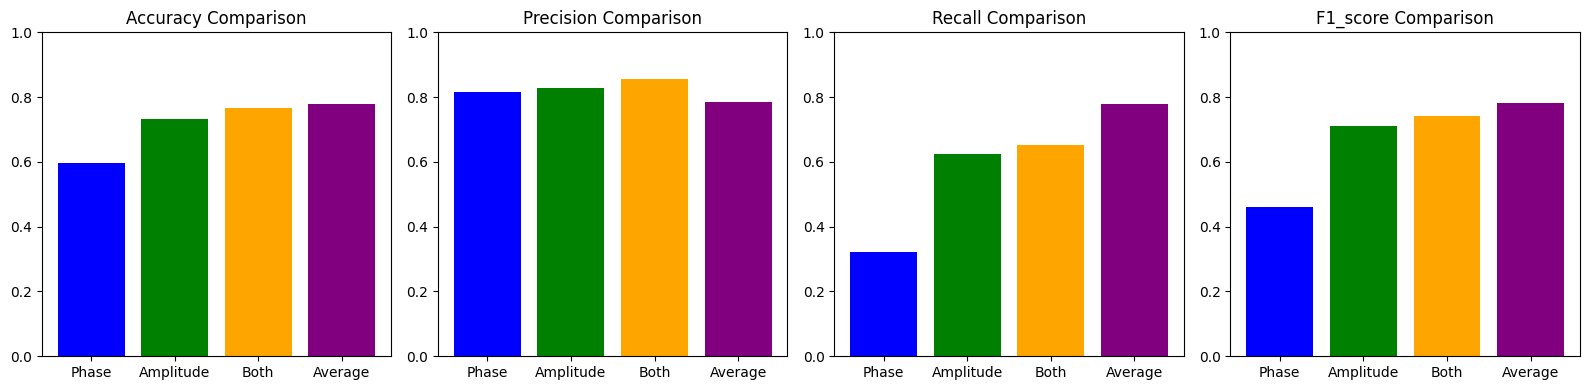

In [ ]:
import matplotlib.pyplot as plt

# Define model names and corresponding metrics
models = ['Phase', 'Amplitude', 'Both', 'Average']
accuracies = [accuracy_phase, accuracy_amp,accuracy_overall, ensemble_accuracy]
precisions = [precision_phase, precision_amp, precision_overall, ensemble_precision]
recalls = [recall_phase, recall_amp, recall_overall, ensemble_recall]
F1s = [f1_score_phase, f1_score_amp, f1_score_overall, ensemble_f1_score]
# Plotting
plt.figure(figsize=(16, 4))

# Accuracy comparison
plt.subplot(1, 4, 1)
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'purple'])
plt.title('Accuracy Comparison')
plt.ylim(0, 1)

# Precision comparison
plt.subplot(1, 4, 2)
plt.bar(models, precisions, color=['blue', 'green', 'orange', 'purple'])
plt.title('Precision Comparison')
plt.ylim(0, 1)

# Recall comparison
plt.subplot(1, 4, 3)
plt.bar(models, recalls, color=['blue', 'green', 'orange', 'purple'])
plt.title('Recall Comparison')
plt.ylim(0, 1)

# Recall comparison
plt.subplot(1, 4, 4)
plt.bar(models, F1s, color=['blue', 'green', 'orange', 'purple'])
plt.title('F1_score Comparison')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [70]:
from sklearn.metrics import confusion_matrix
import numpy as np

def class_specific_accuracy(y_true, y_pred, class_label):
    cm = confusion_matrix(y_true, y_pred)
    class_idx = list(set(y_true))  # Get list of classes
    class_idx.sort()  # Sort classes to ensure correct indexing
    true_positives = cm[class_idx.index(class_label), class_idx.index(class_label)]
    total = np.sum(cm[:, class_idx.index(class_label)])

    return true_positives / total if total > 0 else 0

In [ ]:
y_test = np.argmax(y_test, axis=1)

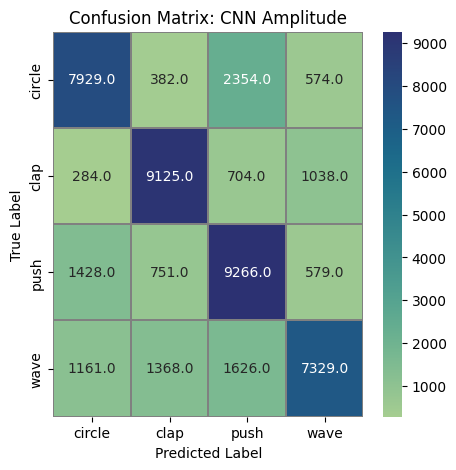

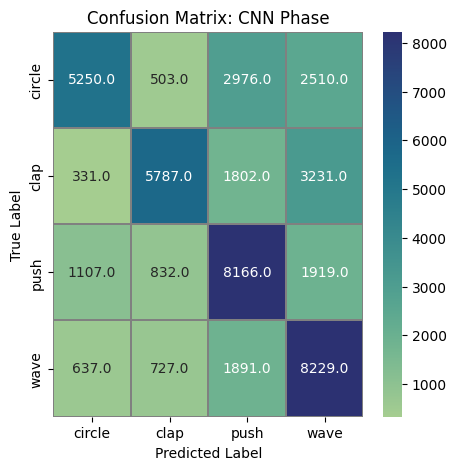

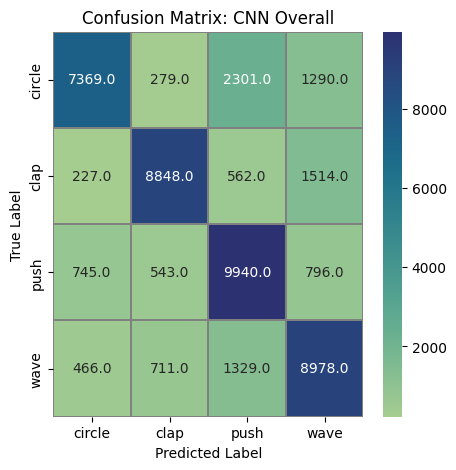

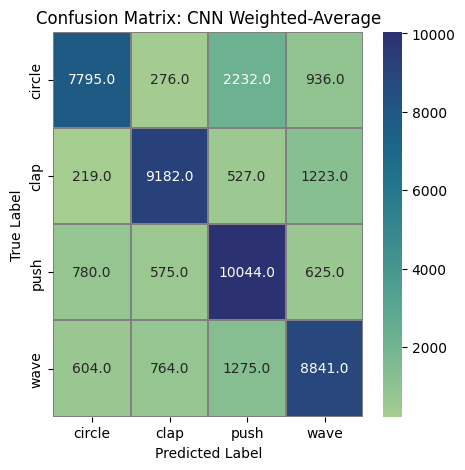

{0: [0.1727526253867271, 0.11438406902261536, 0.1605516580243148, 0.16983310819643557], 1: [0.1988104056821648, 0.12608392522550002, 0.19277528432611443, 0.20005228986012463], 2: [0.20188243496448646, 0.17791624907403372, 0.21656717068281842, 0.21883306462155214], 3: [0.15968016035557106, 0.17928885790230512, 0.19560765174953157, 0.19262277223408428]}


In [71]:
# Get accuracies for each class for each model
classes = np.unique(y_test)  # Assuming y_test is your true labels array
accuracies = {cls: [] for cls in classes}
models = [amplitude_predictions, phase_predictions, overall_predictions, ensemble_predictions]
model_names = ['Amplitude', 'Phase', 'Overall', 'Weighted-Average']

for cls in classes:
    for preds in models:
        preds = np.argmax(preds,axis = 1)
        acc = class_specific_accuracy(y_test, preds, cls)
        accuracies[cls].append(acc)
i=0


for preds in models:
    preds = np.argmax(preds,axis = 1)
    confusion_mtx = confusion_matrix(y_test, preds)  # y_test should also be in encoded form

    # Decoding the labels in y_test for axis ticks if necessary
    tick_labels = label_encoder.inverse_transform(sorted(set(y_test)))  # Use this line if using LabelEncoder

    # Plot the confusion matrix
    f, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="crest", linecolor="gray", fmt='.1f', ax=ax)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(f"Confusion Matrix: CNN {model_names[i]}")
    ax.set_xticklabels(tick_labels)  # Set the tick labels on x-axis
    ax.set_yticklabels(tick_labels)  # Set the tick labels on y-axis
    plt.savefig("/content/drive/MyDrive/real data v1/Images/DL Models/Mixed Points/Confusion Matrix for CNN over "+model_names[i]+" features.png")
    plt.show()

    i += 1

# Print accuracies for verification
print(accuracies)


[0.7331256263889494, 0.5976731012244543, 0.7655017647827792, 0.7813412349121966]
[0.7382479467541594, 0.6305938496084007, 0.7765503433889136, 0.7884557379892342]
[0.7331549386471778, 0.5954485520947548, 0.764399519229058, 0.7805435005817938]
[0.7330184989886147, 0.5960206241978596, 0.7658373775993566, 0.7817242076531471]


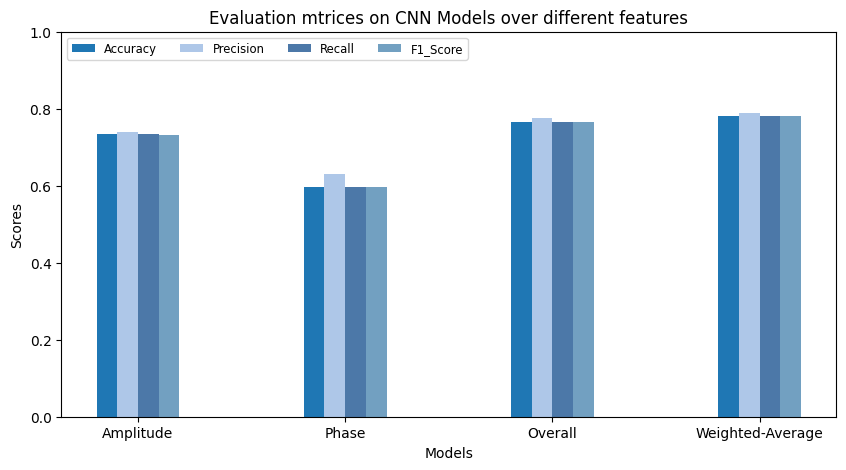

In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = [amplitude_predictions, phase_predictions, overall_predictions, ensemble_predictions]
model_names = ['Amplitude', 'Phase', 'Overall', 'Weighted-Average']

# Assuming y_test is your test labels and models is a list of your trained models
metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1_Score': []
}

for preds in models:
    preds = np.argmax(preds,axis = 1)

    metrics['Accuracy'].append(accuracy_score(y_test, preds))
    metrics['Precision'].append(precision_score(y_test, preds, average='macro'))  # Use 'macro' for multiclass
    metrics['Recall'].append(recall_score(y_test, preds, average='macro'))
    metrics['F1_Score'].append(f1_score(y_test, preds, average='macro'))



# Shades of blue
colors = ['#1f77b4', '#aec7e8', '#4c78a8', '#72A0C1']  # Darker to lighter shades of blue

labels = list(metrics.keys())
x = np.arange(len(model_names))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
for i, (metric, color) in enumerate(zip(metrics, colors)):
    print(metrics[metric])

    ax.bar(x + i * width, metrics[metric], width, label=metric, color=color)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Evaluation mtrices on CNN Models over different features')
ax.set_xticks(x + 0.15)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels(model_names)
ax.legend(loc='upper left', ncols=4, fontsize='small')
plt.savefig("/content/drive/MyDrive/real data v1/Images/DL Models/Mixed Points/ML Evaluation Matrices "+model_names[i]+" model.png")
plt.show()


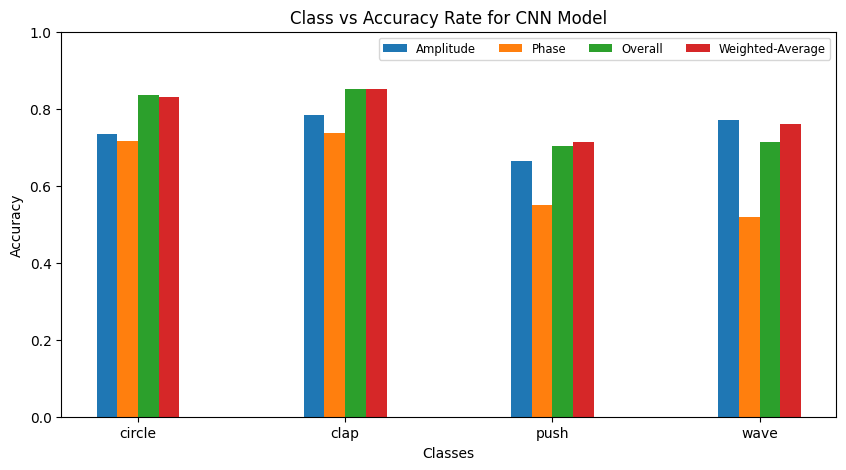

In [63]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Data to plot
class_labels = [str(cls) for cls in label_encoder.inverse_transform(classes)]
x = np.arange(len(class_labels))  # the label locations
width = 0.1  # the width of the bars

# Generate bars for each model
for i, model_name in enumerate(model_names):
    ax.bar(x + i*width, [accuracies[cls][i] for cls in classes], width, label=model_name)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Classes')
ax.set_ylabel('Accuracy')
ax.set_title('Class vs Accuracy Rate for CNN Model')
ax.set_xticks(x + width * (len(models) - 1) / 2)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels(class_labels)

ax.legend(loc='upper right', ncols=4, fontsize='small')

# Show the plot
plt.savefig("/content/drive/MyDrive/real data v1/Images/DL Models/Mixed Points/CNN Comparison "+model_names[i]+" model.png")
plt.show()


In [67]:
print(accuracies)

{0: [0.734030735049065, 0.7167235494880546, 0.8367207902804588, 0.8294317939987231], 1: [0.7848787201100981, 0.7372913746974137, 0.8523263654753878, 0.8504214133555618], 2: [0.6642293906810036, 0.5504550050556117, 0.7033682422870082, 0.7134536155703936], 3: [0.7698529411764706, 0.5179054691925231, 0.7137859755128001, 0.7605161290322581]}


In [66]:
from sklearn.metrics import classification_report

# Calculate classification report
report = classification_report(y_test, ensemble_predicted_labels, digits=4)

# Print the report
print(report)

              precision    recall  f1-score   support

           0     0.8294    0.6936    0.7554     11239
           1     0.8504    0.8234    0.8367     11151
           2     0.7135    0.8353    0.7696     12024
           3     0.7605    0.7699    0.7652     11484

    accuracy                         0.7813     45898
   macro avg     0.7885    0.7805    0.7817     45898
weighted avg     0.7869    0.7813    0.7813     45898



In [68]:
from sklearn.metrics import classification_report

# Calculate classification report
report = classification_report(y_test, amplitude_predicted_labels, digits=4)

# Print the report
print(report)

              precision    recall  f1-score   support

           0     0.7340    0.7055    0.7195     11239
           1     0.7849    0.8183    0.8012     11151
           2     0.6642    0.7706    0.7135     12024
           3     0.7699    0.6382    0.6979     11484

    accuracy                         0.7331     45898
   macro avg     0.7382    0.7332    0.7330     45898
weighted avg     0.7371    0.7331    0.7324     45898



In [69]:
from sklearn.metrics import classification_report

# Calculate classification report
report = classification_report(y_test, phase_predicted_labels, digits=4)

# Print the report
print(report)

              precision    recall  f1-score   support

           0     0.7167    0.4671    0.5656     11239
           1     0.7373    0.5190    0.6092     11151
           2     0.5505    0.6791    0.6081     12024
           3     0.5179    0.7166    0.6012     11484

    accuracy                         0.5977     45898
   macro avg     0.6306    0.5954    0.5960     45898
weighted avg     0.6284    0.5977    0.5962     45898



In [72]:
from sklearn.metrics import classification_report

# Calculate classification report
report = classification_report(y_test, overall_predicted_labels, digits=4)

# Print the report
print(report)

              precision    recall  f1-score   support

           0     0.8367    0.6557    0.7352     11239
           1     0.8523    0.7935    0.8218     11151
           2     0.7034    0.8267    0.7601     12024
           3     0.7138    0.7818    0.7462     11484

    accuracy                         0.7655     45898
   macro avg     0.7766    0.7644    0.7658     45898
weighted avg     0.7748    0.7655    0.7655     45898



#**Try with Fixed point Data**

In [ ]:
# Load the train dataset
df = pd.read_csv('/content/drive/MyDrive/real data v1/fixed_point_data.csv')

X = df.iloc[:, 1:-1].values # All rows, all columns
y = df.iloc[:, -1].values # Labels

# Preprocess the data for amplitude
label_encoder = LabelEncoder()
y_integers = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_integers)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape((X.shape[0], X.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)



In [ ]:
# Build the CNN model for both amplitude and phase
model_overall1 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')  # Output layer: one neuron per class
])

# Compile the overall model
model_overall1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Train the overall model
history = model_overall1.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/10
2712/2712 [==============================] - 109s 39ms/step - loss: 1.0092 - accuracy: 0.5338 - precision_4: 0.6937 - recall_4: 0.3436 - val_loss: 0.7704 - val_accuracy: 0.6595 - val_precision_4: 0.7929 - val_recall_4: 0.4929
Epoch 2/10
2712/2712 [==============================] - 109s 40ms/step - loss: 0.7957 - accuracy: 0.6360 - precision_4: 0.7569 - recall_4: 0.4967 - val_loss: 0.6356 - val_accuracy: 0.7189 - val_precision_4: 0.8147 - val_recall_4: 0.6012
Epoch 3/10
2712/2712 [==============================] - 107s 40ms/step - loss: 0.7257 - accuracy: 0.6714 - precision_4: 0.7769 - recall_4: 0.5519 - val_loss: 0.5841 - val_accuracy: 0.7515 - val_precision_4: 0.8373 - val_recall_4: 0.6410
Epoch 4/10
2712/2712 [==============================] - 102s 38ms/step - loss: 0.6855 - accuracy: 0.6907 - precision_4: 0.7876 - recall_4: 0.5841 - val_loss: 0.5491 - val_accuracy: 0.7657 - val_precision_4: 0.8401 - val_recall_4: 0.6731
Epoch 5/10
2712/2712 [==============================

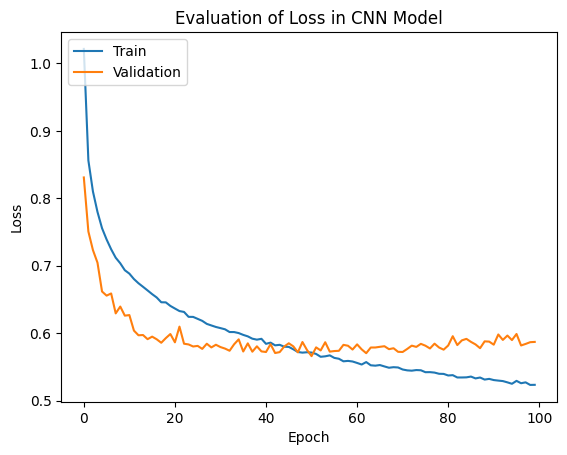

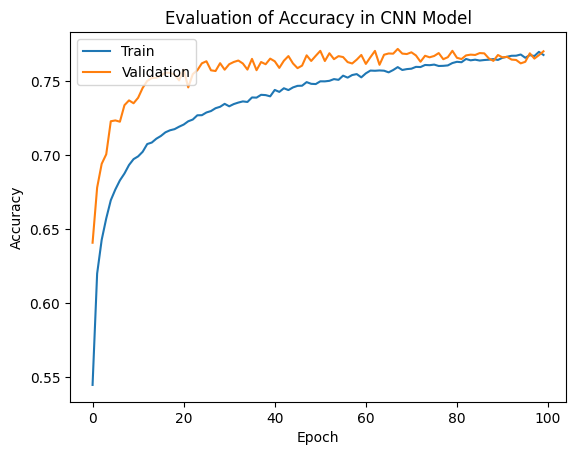

In [ ]:
Plot(history_amp, "")
Plot(history_phase, "")
Plot(history_overall, "")

In [ ]:
# Evaluate the overall model
loss_overall, accuracy_overall, precision_overall, recall_overall = model_overall1.evaluate(X_test, y_test)

print("Overall Model performance on the Fixed data:")
print(f'Test accuracy: {accuracy_overall:.3f}')
print(f'Test precision: {precision_overall:.3f}')
print(f'Test recall: {recall_overall:.3f}')

1356/1356 [==============================] - 11s 8ms/step - loss: 0.5342 - accuracy: 0.7842 - precision_4: 0.8379 - recall_4: 0.7256
Overall Model performance on the Fixed data:
Test accuracy: 0.784
Test precision: 0.838
Test recall: 0.726


In [ ]:
overal1_pred = model_overall1.predict(X_test)
overal1_pred = np.argmax(overal1_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(y_test, preds)  # y_test should also be in encoded form

# Decoding the labels in y_test for axis ticks if necessary
tick_labels = label_encoder.inverse_transform(sorted(set(y_test)))  # Use this line if using LabelEncoder

# Plot the confusion matrix
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="crest", linecolor="gray", fmt='.1f', ax=ax)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title(f"Confusion Matrix: CNN {model_names[i]}")
ax.set_xticklabels(tick_labels)  # Set the tick labels on x-axis
ax.set_yticklabels(tick_labels)  # Set the tick labels on y-axis
plt.savefig("/content/drive/MyDrive/real data v1/Images/DL Models/Mixed Points/Confusion Matrix for CNN over "+model_names[i]+" features.png")
plt.show()


1356/1356 [==============================] - 12s 9ms/step


NameError: name 'confusion_matrix' is not defined

In [ ]:

# Make predictions using the amplitude model
amplitude_predictions1 = model_amp1.predict(X_test_amplitude1)

# Make predictions using the phase model
phase_predictions1 = model_phase1.predict(X_test_phase1)

# Make predictions using the phase model
overall_predictions1 = model_overall1.predict(X_test1)

# Combine predictions using averaging
ensemble_predictions1 = (amplitude_predictions1 + phase_predictions1 + overall_predictions1) / 3

In [ ]:
# Evaluate the amplitude model
loss_amp1, accuracy_amp1, precision_amp1, recall_amp1 = model_amp1.evaluate(X_test_amplitude1, y_test1)

print("Amplitude Model performance on the test data:")
print(f'Test accuracy: {accuracy_amp1:.3f}')
print(f'Test precision: {precision_amp1:.3f}')
print(f'Test recall: {recall_amp1:.3f}')

# Evaluate the phase model
loss_phase1, accuracy_phase1, precision_phase1, recall_phase1 = model_phase1.evaluate(X_test_phase1, y_test1)

print("Phase Model performance on the test data:")
print(f'Test accuracy: {accuracy_phase1:.3f}')
print(f'Test precision: {precision_phase1:.3f}')
print(f'Test recall: {recall_phase1:.3f}')

# Evaluate the overall model
loss_overall1, accuracy_overall1, precision_overall1, recall_overall1 = model_overall1.evaluate(X_test1, y_test1)

print("Overall Model performance on the test data:")
print(f'Test accuracy: {accuracy_overall1:.3f}')
print(f'Test precision: {precision_overall1:.3f}')
print(f'Test recall: {recall_overall1:.3f}')




# Convert ensemble predictions to class labels
ensemble_predicted_labels1 = np.argmax(ensemble_predictions1, axis=1)

# Calculate accuracy for ensemble model
ensemble_accuracy1 = accuracy_score(np.argmax(y_test1, axis=1), ensemble_predicted_labels1)

# Calculate precision for ensemble model
ensemble_precision1 = precision_score(np.argmax(y_test1, axis=1), ensemble_predicted_labels1, average='weighted')

# Calculate recall for ensemble model
ensemble_recall1 = recall_score(np.argmax(y_test1, axis=1), ensemble_predicted_labels1, average='weighted')

print("Ensemble Model performance on the test data:")
print(f'Test accuracy: {ensemble_accuracy1:.3f}')
print(f'Test precision: {ensemble_precision1:.3f}')
print(f'Test recall: {ensemble_recall1:.3f}')

In [ ]:
import matplotlib.pyplot as plt

# Define model names and corresponding metrics
models = ['Phase', 'Amplitude', 'Overall','Ensemble']
accuracies = [accuracy_phase1, accuracy_amp1,accuracy_overall1, ensemble_accuracy1]
precisions = [precision_phase1, precision_amp1, precision_overall1, ensemble_precision1]
recalls = [recall_phase1, recall_amp1, recall_overall1, ensemble_recall1]

# Plotting
plt.figure(figsize=(12, 4))

# Accuracy comparison
plt.subplot(1, 3, 1)
plt.bar(models, accuracies, ['red', 'cyan', 'magenta', 'yellow'])
plt.title('Accuracy Comparison for Fixed Positions')
plt.ylim(0, 1)

# Precision comparison
plt.subplot(1, 3, 2)
plt.bar(models, precisions, ['red', 'cyan', 'magenta', 'yellow'])
plt.title('Precision Comparison for Fixed Positions')
plt.ylim(0, 1)

# Recall comparison
plt.subplot(1, 3, 3)
plt.bar(models, recalls, ['red', 'cyan', 'magenta', 'yellow'])
plt.title('Recall Comparison for Fixed Positions')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
generate_confusion_matrix(amplitude_predictions1, "Amplitude Model for Fixed Positions", "Reds" )
generate_confusion_matrix(phase_predictions1, "Phase Model for Fixed Positions", "Cyans" )
generate_confusion_matrix(ensemble_predictions1, "Overall Model for Fixed Positions", "Megentas" )
generate_confusion_matrix(ensemble_predictions1, "Ensamble Model for Fixed Positions", "Yellows" )